In [1]:
import os
os.chdir('../../../../data')
!ls

FAOSTAT_A-S_E                       area_reductions
FAOSTAT_T-Z_E                       countries_codes_and_coordinates.csv
GAEZ_2015                           livestock_2010
SPAM_2010                           ppp_2020_1km_Aggregated.tif
UNSD — Methodology.csv              s41597-021-01115-2.pdf
admin_polygons                      transport_sample.csv
admin_polygons.gpkg


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [254]:
import matplotlib.pyplot as plt

In [3]:
item = 'Maize (corn)'
year = 2020

## Areas

In [4]:
area_codes = pd.read_csv('countries_codes_and_coordinates.csv')

In [5]:
area_codes['Alpha-3 code'] = area_codes.apply(lambda row: row['Alpha-3 code'].split('"')[1], axis=1)
area_codes['Numeric code'] = area_codes.apply(lambda row: int(row['Numeric code'].split('"')[1]), axis=1)
area_codes = area_codes[['Alpha-3 code', 'Numeric code']].rename(
    columns={'Alpha-3 code': 'iso3', 'Numeric code': 'Area Code (M49)'})

In [6]:
area_codes.head()

,iso3,Area Code (M49)
0,AFG,4
1,XAD,-1
2,ALA,248
3,ALB,8
4,DZA,12


In [7]:
area_codes.shape

(253, 2)

In [8]:
admin = gpd.read_file('admin_polygons.gpkg')

In [9]:
admin = admin[['ID', 'iso3', 'country', 'admin', 'admin_name', 'latitude', 'longitude']]
admin['country'].nunique()

240

In [10]:
maize_areas = pd.read_csv('area_reductions/maize_areas.csv').drop(['system:index', '.geo'], axis=1)
banana_areas = pd.read_csv('area_reductions/banana_areas.csv').drop(['system:index', '.geo'], axis=1)
soybean_areas = pd.read_csv('area_reductions/soybean_areas.csv').drop(['system:index', '.geo'], axis=1)
cattle_counts = pd.read_csv('area_reductions/cattle_areas.csv').drop(['system:index', '.geo'], axis=1)
coffee_areas = pd.read_csv('area_reductions/coffee_areas.csv').drop(['system:index', '.geo'], axis=1)
pop_counts = pd.read_csv('area_reductions/pop_areas.csv').drop(['system:index', '.geo'], axis=1)

In [11]:
maize_areas.head()

,ID,admin,admin_name,country,iso3,latitude,longitude,maize_sum
0,AFG.1_1,admin1,Badakhshan,Afghanistan,AFG,37.032895,71.458977,1650.748531
1,AFG.2_1,admin1,Badghis,Afghanistan,AFG,35.139751,63.752696,3088.383955
2,AFG.3_1,admin1,Baghlan,Afghanistan,AFG,35.705362,68.713877,2212.028742
3,AFG.4_1,admin1,Balkh,Afghanistan,AFG,36.648028,67.134957,11855.269809
4,AFG.6_1,admin1,Daykundi,Afghanistan,AFG,33.754922,66.183993,320.851629


## Production, trade

In [12]:
prod = pd.read_csv('FAOSTAT_A-S_E/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_All_Data_(Normalized).csv',
                   encoding='latin1')
prod_area_codes = pd.read_csv('FAOSTAT_A-S_E/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_AreaCodes.csv',
                               encoding='latin1')
prod_flags = pd.read_csv('FAOSTAT_A-S_E/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_Flags.csv',
                          encoding='latin1')
prod_ItemCodes = pd.read_csv('FAOSTAT_A-S_E/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_ItemCodes.csv',
                              encoding='latin1')


In [13]:
prod = prod[['Area Code (M49)', 'Area', 'Item', 'Element', 'Year', 'Unit', 'Value']]

In [14]:
prod = prod[(prod['Year']==year) & (prod['Item']==item) & (prod['Element']=='Production')].reset_index(drop=True)

In [15]:
prod = prod.rename(columns={'Value': 'Production'})
prod = prod.drop('Element', axis=1)
prod.head()

,Area Code (M49),Area,Item,Year,Unit,Production
0,'004,Afghanistan,Maize (corn),2020,tonnes,271776.0
1,'008,Albania,Maize (corn),2020,tonnes,399125.0
2,'012,Algeria,Maize (corn),2020,tonnes,3221.0
3,'024,Angola,Maize (corn),2020,tonnes,2972177.0
4,'028,Antigua and Barbuda,Maize (corn),2020,tonnes,11.4


In [16]:
mat = pd.read_csv('FAOSTAT_T-Z_E/Trade_DetailedTradeMatrix_E_All_Data_(Normalized)/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv',
                encoding='latin1')

In [17]:
mat = mat[(mat['Year']==year) & (mat['Item']==item) 
        & (mat['Unit']=='tonnes')][['Reporter Country Code (M49)', 'Partner Country Code (M49)',
    'Reporter Countries', 'Partner Countries', 'Item', 'Element', 'Year', 'Unit', 'Value']].reset_index(drop=True)

In [18]:
mat.shape

(4783, 9)

In [19]:
# reliability index - Reconciling bilateral trade data for use in GTAP
# accuracy level for each import 
imports = mat[mat['Element']=='Import Quantity']
imports = imports.rename(columns={'Reporter Countries': 'Country A', 'Partner Countries': 'Country B',
                                  'Reporter Country Code (M49)': 'Country A Code', 'Partner Country Code (M49)': 'Country B Code'})
exports = mat[mat['Element']=='Export Quantity']
exports = exports.rename(columns={'Reporter Countries': 'Country B', 'Partner Countries': 'Country A',
                                  'Reporter Country Code (M49)': 'Country B Code', 'Partner Country Code (M49)': 'Country A Code'})
df = pd.concat([imports, exports], axis=0, ignore_index=True)
df = pd.pivot(df, index=['Country A', 'Country B', 'Country A Code', 'Country B Code', 'Item', 'Year', 'Unit'], 
              columns = 'Element',values = 'Value').reset_index()
df = df.fillna(0)
df = df.rename(columns={'Import Quantity': 'Import rep A', 'Export Quantity': 'Export rep B',})

In [20]:
df = df[(df['Import rep A']!=0) | (df['Export rep B']!=0)].reset_index(drop=True)

In [21]:
df.shape

(2934, 9)

In [22]:
# df['AL'] = (df['Import rep A'] - df['Export rep B']).abs()/df['Import rep A']

In [23]:
df['AL'] = 2*(df['Import rep A'] - df['Export rep B']).abs()/(df['Import rep A'] + df['Export rep B'])

In [24]:
row_cond = (df['AL']==2) & (df['Import rep A']<10) & (df['Export rep B']<10)
df.loc[row_cond, 'AL'] = -1

In [25]:
def calc_rel_index(g, col, ind_col):
    d = g.copy()
    d = d[d['AL']!=-1]
    # d['WAL'] = d[col] / d[col].sum() * d['AL']
    # d = d[d['WAL']!=d['WAL'].max()]
    RI = d[d['AL']<=0.2][col].sum() / d[col].sum()
    g[ind_col] = RI 
    return g

In [26]:
df = df.groupby('Country A').apply(lambda g: calc_rel_index(g, 'Import rep A', 'RIM')).reset_index(drop=True)
df = df.groupby('Country B').apply(lambda g: calc_rel_index(g, 'Export rep B', 'RIX')).reset_index(drop=True)
df = df.fillna(0)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [27]:
df.head()

Element,Country A,Country B,Country A Code,Country B Code,Item,Year,Unit,Export rep B,Import rep A,AL,RIM,RIX
0,Afghanistan,Pakistan,'004,'586,Maize (corn),2020,tonnes,2808.00,0.00,2.000000,0.000000,0.649201
1,Afghanistan,United Arab Emirates,'004,'784,Maize (corn),2020,tonnes,0.52,0.00,-1.000000,0.000000,0.195788
2,Albania,Argentina,'008,'032,Maize (corn),2020,tonnes,436.40,440.05,0.008329,0.974176,0.800476
3,Albania,Brazil,'008,'076,Maize (corn),2020,tonnes,0.00,21.15,2.000000,0.974176,0.576043
4,Albania,Bulgaria,'008,'100,Maize (corn),2020,tonnes,43.45,0.00,2.000000,0.974176,0.535171


In [28]:
df.shape

(2934, 12)

In [29]:
def _select_qty(row):
    if row['RIM'] >= row['RIX']:
        return row['Import rep A']
    else:
        return row['Export rep B']

df['From B to A'] = df.apply(lambda row: _select_qty(row), axis=1)

In [30]:
total_imports = df.groupby(['Country A']).agg(
    {'Country A Code': 'first', 'Item': 'first', 'Year': 'first', 'Unit': 'first', 'From B to A': 'sum'}).reset_index()
total_imports = total_imports.rename(columns={'Country A': 'Area', 'Country A Code': 'Area Code (M49)', 'From B to A': 'Import'})

In [31]:
total_exports = df.groupby('Country B').agg(
    {'Country B Code': 'first', 'Item': 'first', 'Year': 'first', 'Unit': 'first', 'From B to A': 'sum'}).reset_index()
total_exports = total_exports.rename(columns={'Country B': 'Area', 'Country B Code': 'Area Code (M49)', 'From B to A': 'Export'})

In [32]:
trade = total_imports.merge(total_exports, how='outer')

In [170]:
overall = trade.merge(prod, how='outer')
overall = overall.fillna(0)

In [171]:
overall['Consumption'] = overall['Production'] + overall['Import'] - overall['Export']

In [172]:
overall['Area Code (M49)'] = overall.apply(lambda row: int(row['Area Code (M49)'][1:]), axis=1)
overall.head()

,Area,Area Code (M49),Item,Year,Unit,Import,Export,Production,Consumption
0,Afghanistan,4,Maize (corn),2020,tonnes,2808.52,215.0,271776.0,274369.52
1,Albania,8,Maize (corn),2020,tonnes,83401.96,0.0,399125.0,482526.96
2,Algeria,12,Maize (corn),2020,tonnes,5010403.34,5.0,3221.0,5013619.34
3,Angola,24,Maize (corn),2020,tonnes,39707.23,84.0,2972177.0,3011800.23
4,Antigua and Barbuda,28,Maize (corn),2020,tonnes,83.89,105.0,11.4,-9.71


In [173]:
overall.shape

(232, 9)

In [174]:
overall = overall.merge(area_codes, how='left')

In [175]:
overall = overall[overall['iso3'].notnull()].reset_index(drop=True)

In [176]:
overall.shape

(198, 10)

In [177]:
overall['iso3'].nunique()

198

In [178]:
overall['Area Code (M49)'].nunique()

198

In [179]:
# negative consumption

In [180]:
df.shape

(2934, 13)

In [181]:
overall[overall['Consumption']<0]

,Area,Area Code (M49),Item,Year,Unit,Import,Export,Production,Consumption,iso3
4,Antigua and Barbuda,28,Maize (corn),2020,tonnes,83.89,105.00,11.4,-9.71,ATG
176,Tonga,776,Maize (corn),2020,tonnes,0.41,0.66,0.0,-0.25,TON


In [182]:
df[df['Country A']=='Antigua and Barbuda']

Element,Country A,Country B,Country A Code,Country B Code,Item,Year,Unit,Export rep B,Import rep A,AL,RIM,RIX,From B to A
40,Antigua and Barbuda,Brazil,'028,'076,Maize (corn),2020,tonnes,2.42,2.42,0.0,1.0,0.576043,2.42
41,Antigua and Barbuda,Canada,'028,'124,Maize (corn),2020,tonnes,18.23,18.23,0.0,1.0,0.971685,18.23
42,Antigua and Barbuda,Jamaica,'028,'388,Maize (corn),2020,tonnes,0.02,0.02,0.0,1.0,0.000041,0.02
43,Antigua and Barbuda,Trinidad and Tobago,'028,'780,Maize (corn),2020,tonnes,0.20,0.20,0.0,1.0,0.377651,0.20
44,Antigua and Barbuda,United States of America,'028,'840,Maize (corn),2020,tonnes,63.02,63.02,0.0,1.0,0.849179,63.02


In [183]:
df[df['Country B']=='Antigua and Barbuda']

Element,Country A,Country B,Country A Code,Country B Code,Item,Year,Unit,Export rep B,Import rep A,AL,RIM,RIX,From B to A
1702,Netherlands,Antigua and Barbuda,'528,'028,Maize (corn),2020,tonnes,81.0,81.0,0.0,0.788587,1.0,81.0
2709,United Kingdom of Great Britain and Northern I...,Antigua and Barbuda,'826,'028,Maize (corn),2020,tonnes,24.0,24.0,0.0,0.366685,1.0,24.0


In [184]:
countries = overall[overall['Consumption']<0]['Area'].unique()

In [185]:
def change_val(df, c):
    
    def _sel_other(r):
        if r['Export rep B']==r['From B to A']:
            return r['Import rep A']
        else:
            return r['Export rep B']
    
    imps = df[df['Country A']==c].copy()
    exps = df[df['Country B']==c].copy()
    sel_imp = None
    sel_exp = None 
    if len(imps)>0:
        imps['diff'] = imps.apply(lambda r: (_sel_other(r) - r['From B to A']), axis=1)
        sel_imp = imps[imps['diff']==imps['diff'].max()]
    if len(exps)>0:
        exps['diff'] = exps.apply(lambda r:  (r['From B to A'] - _sel_other(r)), axis=1)
        sel_exp = exps[exps['diff']==exps['diff'].max()]
    if sel_imp is not None:
        sel_row = sel_imp
        if sel_exp is not None:
            if sel_row['diff'].values[0] < sel_exp['diff'].values[0]:
                sel_row = sel_exp
    else:
        sel_row = sel_exp
    
    row_cond = (df['Country A']==sel_row['Country A'].values[0]) & (df['Country B']==sel_row['Country B'].values[0])
    df.loc[row_cond, 'From B to A'] = df.loc[row_cond, :].apply(lambda r: _sel_other(r), axis=1)
    
    return df

In [186]:
for c in countries:
    df = change_val(df, c)

In [187]:
total_imports = df.groupby(['Country A']).agg(
    {'Country A Code': 'first', 'Item': 'first', 'Year': 'first', 'Unit': 'first', 'From B to A': 'sum'}).reset_index()
total_imports = total_imports.rename(columns={'Country A': 'Area', 'Country A Code': 'Area Code (M49)', 'From B to A': 'Import'})

total_exports = df.groupby('Country B').agg(
    {'Country B Code': 'first', 'Item': 'first', 'Year': 'first', 'Unit': 'first', 'From B to A': 'sum'}).reset_index()
total_exports = total_exports.rename(columns={'Country B': 'Area', 'Country B Code': 'Area Code (M49)', 'From B to A': 'Export'})

trade = total_imports.merge(total_exports, how='outer')

overall = trade.merge(prod, how='outer')
overall = overall.fillna(0)

overall['Consumption'] = overall['Production'] + overall['Import'] - overall['Export']

overall['Area Code (M49)'] = overall.apply(lambda row: int(row['Area Code (M49)'][1:]), axis=1)

overall = overall.merge(area_codes, how='left')

overall = overall[overall['iso3'].notnull()].reset_index(drop=True)
overall[overall['Consumption']<0]

,Area,Area Code (M49),Item,Year,Unit,Import,Export,Production,Consumption,iso3
4,Antigua and Barbuda,28,Maize (corn),2020,tonnes,83.89,105.00,11.4,-9.71,ATG
176,Tonga,776,Maize (corn),2020,tonnes,0.41,0.66,0.0,-0.25,TON


In [188]:
#cleaning countries etc

In [189]:
admin = admin.merge(area_codes, how='left')

In [190]:
admin.shape

(3787, 8)

In [191]:
admin['iso3'].nunique()

240

In [192]:
admin['Area Code (M49)'].nunique()

238

In [193]:
# outer merge includes one additional region called tokelau which doesnt have boundaries,
# probably because it's a combination of boundaries. hence using inner merge
# check that this is the only one in case of other years and crops
overall = admin.merge(overall, how='left')

In [194]:
overall.shape

(3787, 16)

In [195]:
overall['Area Code (M49)'].nunique()

238

In [196]:
overall['iso3'].nunique()

240

In [197]:
# some area codes are missing in the area code data - maybe this can be fixed
overall[overall['Area Code (M49)']==-1]['iso3'].unique() # Akrotiri and Dhekelia, Kosovo, Northern Cyprus

array(['XAD', 'XKO', 'XNC'], dtype=object)

In [198]:
overall[overall['Area Code (M49)']==-1].shape # admins in Akrotiri and Dhekelia, Kosovo, Northern Cyprus,

(14, 16)

In [199]:
overall[overall.isna().any(axis=1)].shape # number of admins with no FAO data

(248, 16)

In [200]:
# all the above are missing in FAO data as well + some more 
# this is probably because of geopolitical issues - even the rasters dont report any data for some of these regions
# will need to look into this in detail - for some, they would have to be merged with other regions
# some such as western sahara would have to be removed from analysis?
overall[overall.isna().any(axis=1)][['Area', 'Area Code (M49)', 'country', 'iso3', 
                                     'Item', 'Year', 'Unit', 'Import', 'Export', 
                                     'Production', 'Consumption']].drop_duplicates() # unique "countries" with no FAO data

,Area,Area Code (M49),country,iso3,Item,Year,Unit,Import,Export,Production,Consumption
235,NaN,248,Åland,ALA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,NaN,20,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,NaN,16,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,NaN,260,French Southern Territories,ATF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
390,NaN,535,"Bonaire, Sint Eustatius and Saba",BES,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493,NaN,60,Bermuda,BMU,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,NaN,136,Cayman Islands,CYM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,NaN,732,Western Sahara,ESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1137,NaN,831,Guernsey,GGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170,NaN,312,Guadeloupe,GLP,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
overall[overall.isna().any(axis=1)][['Area', 'Area Code (M49)', 'country', 'iso3']].drop_duplicates().shape

(43, 4)

In [202]:
overall = overall[overall.notnull().all(axis=1)].reset_index(drop=True)

In [203]:
overall.shape

(3539, 16)

In [204]:
# compare with fao trade data 

In [205]:
trade_fao = pd.read_csv('FAOSTAT_T-Z_E/Trade_CropsLivestock_E_All_Data_(Normalized)/Trade_CropsLivestock_E_All_Data_(Normalized).csv',
                   encoding='latin1')
trade_area_codes = pd.read_csv('FAOSTAT_T-Z_E/Trade_CropsLivestock_E_All_Data_(Normalized)/Trade_CropsLivestock_E_AreaCodes.csv',
                               encoding='latin1')
trade_flags = pd.read_csv('FAOSTAT_T-Z_E/Trade_CropsLivestock_E_All_Data_(Normalized)/Trade_CropsLivestock_E_Flags.csv',
                          encoding='latin1')
trade_ItemCodes = pd.read_csv('FAOSTAT_T-Z_E/Trade_CropsLivestock_E_All_Data_(Normalized)/Trade_CropsLivestock_E_ItemCodes.csv',
                              encoding='latin1')

In [206]:
trade_fao = trade_fao[(trade_fao['Item']==item) & (trade_fao['Year']==year) & (trade_fao['Unit']=='tonnes')]

In [207]:
trade_fao = pd.pivot(trade_fao, index=['Area', 'Item', 'Year', 'Unit'], columns = 'Element',values = 'Value').reset_index()
trade_fao = trade_fao.fillna(0)

In [208]:
trade_fao.shape

(262, 6)

In [209]:
trade.shape

(196, 7)

In [210]:
f = trade.merge(trade_fao, how='left')
f.shape

(196, 9)

In [211]:
f = f.fillna(0)

<AxesSubplot:xlabel='Export', ylabel='Export Quantity'>

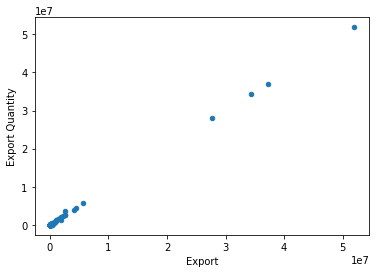

In [212]:
f.plot.scatter('Export', 'Export Quantity')

<AxesSubplot:xlabel='Import', ylabel='Import Quantity'>

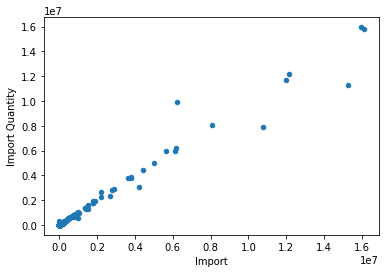

In [213]:
f.plot.scatter('Import', 'Import Quantity')

In [214]:
f[['Import', 'Import Quantity']].corr()

Element,Import,Import Quantity
Element,,
Import,1.000000,0.985444
Import Quantity,0.985444,1.000000


In [215]:
f[['Export', 'Export Quantity']].corr()

Element,Export,Export Quantity
Element,,
Export,1.000000,0.999801
Export Quantity,0.999801,1.000000


In [216]:
## proportions

In [217]:
overall = overall.drop(['Area Code (M49)', 'Area'], axis=1)
overall.head()

,ID,iso3,country,admin,admin_name,latitude,longitude,Item,Year,Unit,Import,Export,Production,Consumption
0,GBR.1.1_1,GBR,United Kingdom,admin2,Barnsley,53.526238,-1.533560,Maize (corn),2020.0,tonnes,2180467.8,166038.09,0.0,2014429.71
1,GBR.1.2_1,GBR,United Kingdom,admin2,Bath and North East Somerset,51.355271,-2.469959,Maize (corn),2020.0,tonnes,2180467.8,166038.09,0.0,2014429.71
2,GBR.1.3_1,GBR,United Kingdom,admin2,Bedfordshire,52.195932,-0.489157,Maize (corn),2020.0,tonnes,2180467.8,166038.09,0.0,2014429.71
3,GBR.1.4_1,GBR,United Kingdom,admin2,Birmingham,52.484500,-1.864205,Maize (corn),2020.0,tonnes,2180467.8,166038.09,0.0,2014429.71
4,GBR.1.5_1,GBR,United Kingdom,admin2,Blackburn with Darwen,53.695140,-2.469856,Maize (corn),2020.0,tonnes,2180467.8,166038.09,0.0,2014429.71


In [226]:
overall = overall.merge(maize_areas.merge(pop_counts)[['ID', 'maize_sum', 'pop_sum']])

In [235]:
def _get_props(g, col1, col2, col3):
    g[col3] = (g[col2] / g[col2].sum()) * g[col1]
    return g

overall = overall.groupby('iso3').apply(lambda g: _get_props(g, 'Production', 'maize_sum', 'admin_maize_prod'))
overall = overall.groupby('iso3').apply(lambda g: _get_props(g, 'Consumption', 'pop_sum', 'admin_maize_cons'))

In [237]:
overall = overall.fillna(0)
overall.loc[overall['admin_maize_cons']<0, 'admin_maize_cons'] = 0

In [270]:
admin = gpd.read_file('admin_polygons/admin_polygons.shp')
admin = admin[['ID', 'geometry']]

In [271]:
admin = admin.merge(overall, how='right')

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/mapclassify/classifiers.py:258: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 9.
  UserWarning,


Text(0.5, 1.0, 'Maize production (tonnes)')

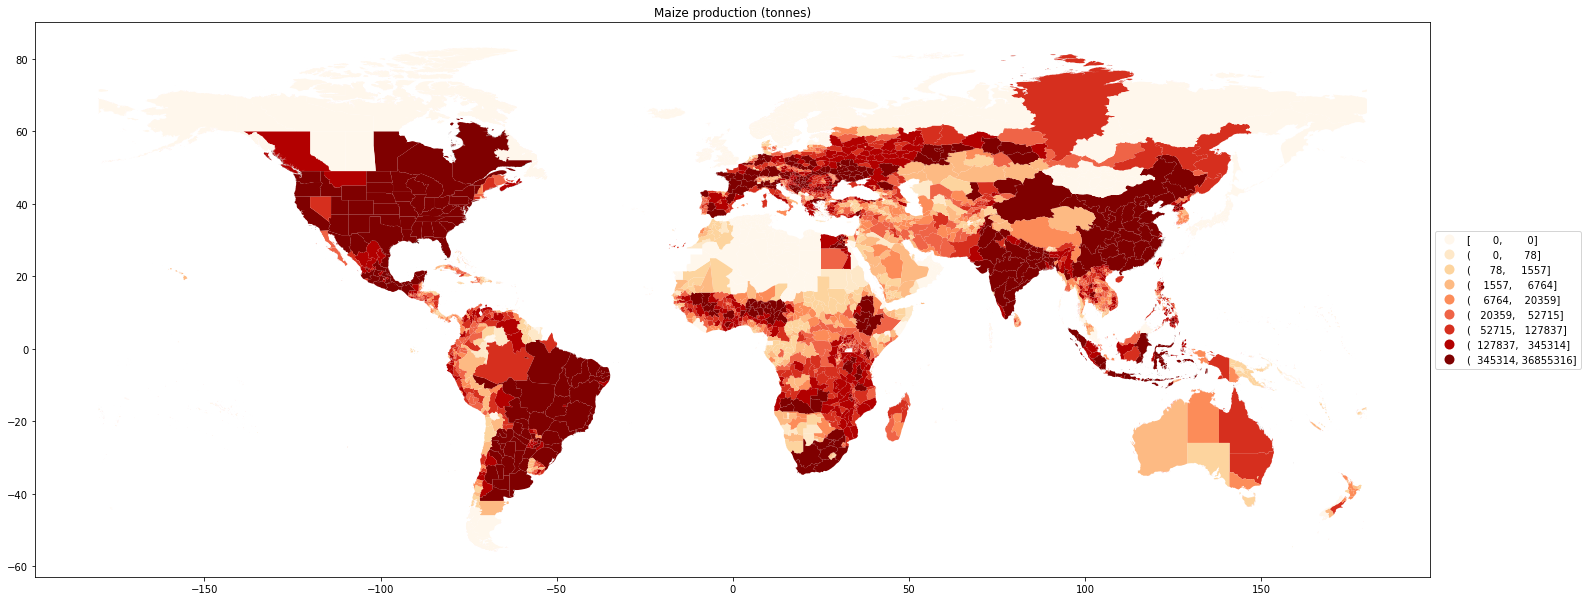

In [273]:
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
admin.plot(column='admin_maize_prod', ax=ax, legend=True, cmap='OrRd', scheme = 'quantiles', k=10,
      legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),  'fmt':"{:.0f}"})
ax.set_title("Maize production (tonnes)")

Text(0.5, 1.0, 'Maize consumption (tonnes)')

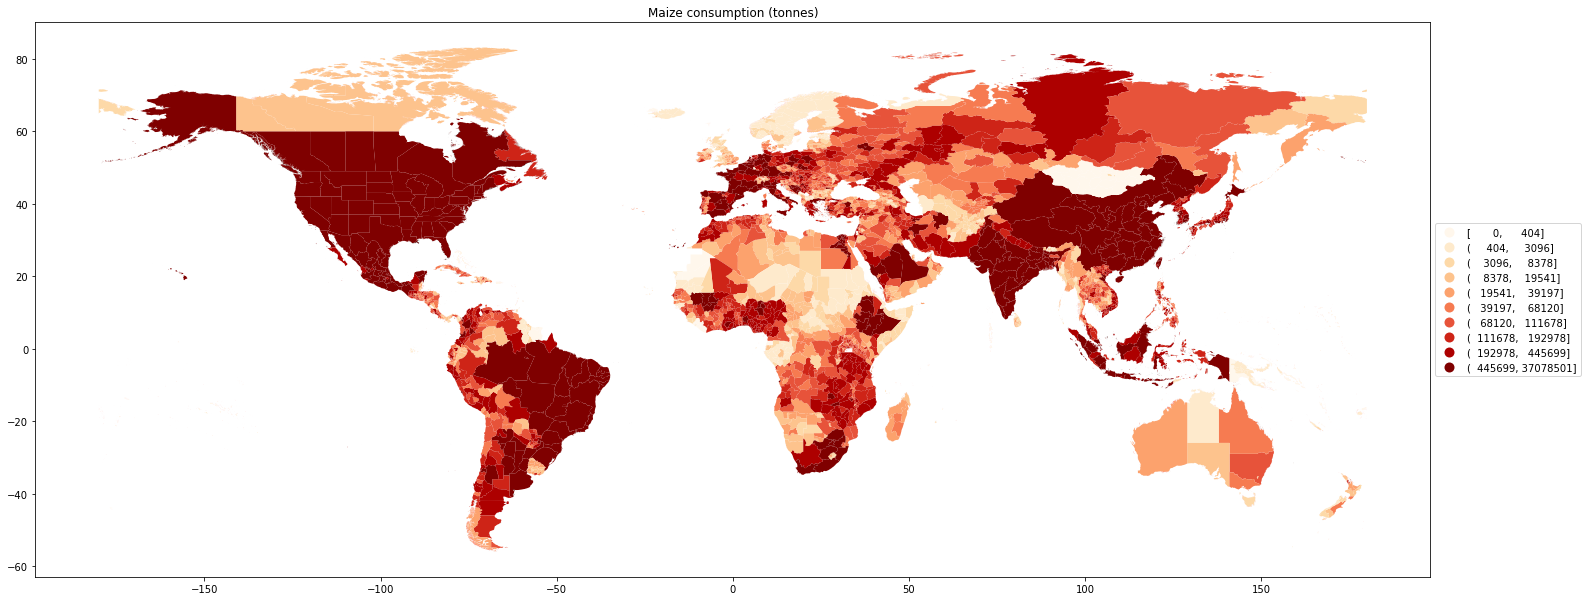

In [274]:
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
admin.plot(column='admin_maize_cons', ax=ax, legend=True, cmap='OrRd', scheme = 'quantiles', k=10,
      legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),  'fmt':"{:.0f}"})
ax.set_title("Maize consumption (tonnes)")

#### next steps
- previous years - country discrepancies 
- compare with available sub national data